### This (auxiliary) notebook shows MNIST classifier training and evaluation according to conventional performance metrics, and GAN training for each digit class

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [18]:
from datasets import *
from ml_util import *
from cnn import *
from gan import *
from adversarial_generation import *
from evaluation_util import EvaluationUtil
from generative import WGAN

### Load dataset

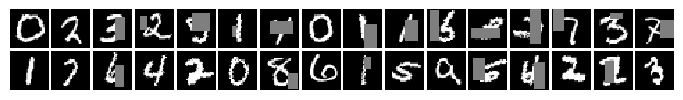

In [3]:
ds = MNISTData()
# get some random training images
images, _ = next(iter(ds.get_train_loader()))
Util.imshow_tensors(images, nrow=16)

### Load classifiers

In [5]:
filenames = "oneepoch plain conventional robust both".split(" ")
unit_types = [0, 1, 2]
def load_classifier(filename: str, unit_type: int):   
    weights_filename = f"classifiers_architecture{unit_type}/{filename}_MNIST.bin"
    c = Trainer("mnist", ds.get_train_loader, ds.get_test_loader, unit_type)
    c.restore_params_from_disk(weights_filename)
    return c
classifiers = [load_classifier(filename, unit_type) for unit_type in unit_types for filename in filenames]

mnist classifier: 23394 trainable parameters
mnist classifier: 23394 trainable parameters
mnist classifier: 23394 trainable parameters
mnist classifier: 23394 trainable parameters
mnist classifier: 23394 trainable parameters
mnist classifier: 17058 trainable parameters
mnist classifier: 17058 trainable parameters
mnist classifier: 17058 trainable parameters
mnist classifier: 17058 trainable parameters
mnist classifier: 17058 trainable parameters
mnist classifier: 35658 trainable parameters
mnist classifier: 35658 trainable parameters
mnist classifier: 35658 trainable parameters
mnist classifier: 35658 trainable parameters
mnist classifier: 35658 trainable parameters


### A few predictions

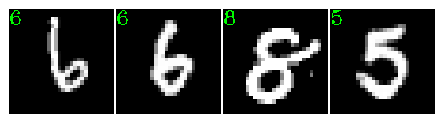

Predicted 0: ['6', '6', '8', '5']
Predicted 1: ['6', '6', '8', '5']
Predicted 2: ['6', '6', '8', '5']
Predicted 3: ['6', '6', '8', '5']
Predicted 4: ['6', '6', '8', '5']
Predicted 5: ['6', '6', '8', '5']
Predicted 6: ['6', '6', '8', '5']
Predicted 7: ['6', '6', '8', '5']
Predicted 8: ['6', '6', '8', '5']
Predicted 9: ['6', '6', '8', '5']
Predicted 10: ['6', '6', '8', '5']
Predicted 11: ['6', '6', '8', '5']
Predicted 12: ['6', '6', '8', '5']
Predicted 13: ['6', '6', '8', '5']
Predicted 14: ['6', '6', '8', '5']


In [6]:
EvaluationUtil.show_some_predictions(classifiers, ds)

### Classifier evaluation: clean accuracy and noise corruption accuracy (on the validation set)

In [5]:
EvaluationUtil.evaluate_accuracy(classifiers, ds, 100)

Accuracy of classifier 0 on 100 validation images (noise 0.0):  94.00%
Accuracy of classifier 0 on 100 validation images (noise 0.8):  91.00%
Accuracy of classifier 1 on 100 validation images (noise 0.0):  99.00%
Accuracy of classifier 1 on 100 validation images (noise 0.8):  81.00%
Accuracy of classifier 2 on 100 validation images (noise 0.0): 100.00%
Accuracy of classifier 2 on 100 validation images (noise 0.8):  87.00%
Accuracy of classifier 3 on 100 validation images (noise 0.0):  99.00%
Accuracy of classifier 3 on 100 validation images (noise 0.8):  95.00%
Accuracy of classifier 4 on 100 validation images (noise 0.0):  96.00%
Accuracy of classifier 4 on 100 validation images (noise 0.8):  98.00%


### Evaluation: adversarial frequency and severity in the original space (on the validation set)

* Adversarial frequency = accuracy on worst-case perturbed images within allowed bounds
* Adversarial severity = expected size of a minimum adversarial perturbation

In [6]:
EvaluationUtil.evaluate_conventional_robustness(classifiers, ds, 4, l_2_bounds=[0.1, 0.15], l_inf_bounds=[0.15, 0.25])

For classifier 0, (scaled_l_2) ║Δx║ ≤ 0.100000, accuracy on 4 images =  50.00%
For classifier 1, (scaled_l_2) ║Δx║ ≤ 0.100000, accuracy on 4 images =  25.00%
For classifier 2, (scaled_l_2) ║Δx║ ≤ 0.100000, accuracy on 4 images =  50.00%
For classifier 3, (scaled_l_2) ║Δx║ ≤ 0.100000, accuracy on 4 images =  50.00%
For classifier 4, (scaled_l_2) ║Δx║ ≤ 0.100000, accuracy on 4 images = 100.00%
For classifier 0, (scaled_l_2) ║Δx║ ≤ 0.150000, accuracy on 4 images =   0.00%
For classifier 1, (scaled_l_2) ║Δx║ ≤ 0.150000, accuracy on 4 images =   0.00%
For classifier 2, (scaled_l_2) ║Δx║ ≤ 0.150000, accuracy on 4 images =   0.00%
For classifier 3, (scaled_l_2) ║Δx║ ≤ 0.150000, accuracy on 4 images =  50.00%
For classifier 4, (scaled_l_2) ║Δx║ ≤ 0.150000, accuracy on 4 images =  25.00%
For classifier 0, (     l_inf) ║Δx║ ≤ 0.150000, accuracy on 4 images =  50.00%
For classifier 1, (     l_inf) ║Δx║ ≤ 0.150000, accuracy on 4 images =  50.00%
For classifier 2, (     l_inf) ║Δx║ ≤ 0.150000, accu

In [7]:
EvaluationUtil.evaluate_conventional_adversarial_severity(classifiers, ds, 4, MNIST_L2_UPPER_BOUND, MNIST_LINF_UPPER_BOUND)

Adversarial severity of classifier 0 with scaled_l_2 norm = 0.08688106 (std = 0.01868625, #images = 4)
Adversarial severity of classifier 1 with scaled_l_2 norm = 0.09289630 (std = 0.00698460, #images = 4)
Adversarial severity of classifier 2 with scaled_l_2 norm = 0.08652056 (std = 0.00804153, #images = 4)
Adversarial severity of classifier 3 with scaled_l_2 norm = 0.10872525 (std = 0.11030192, #images = 4)
Adversarial severity of classifier 4 with scaled_l_2 norm = 0.17795698 (std = 0.11960219, #images = 4)
Adversarial severity of classifier 0 with      l_inf norm = 0.17985156 (std = 0.05746274, #images = 4)
Adversarial severity of classifier 1 with      l_inf norm = 0.17577921 (std = 0.03311304, #images = 4)
Adversarial severity of classifier 2 with      l_inf norm = 0.31180868 (std = 0.11043904, #images = 4)
Adversarial severity of classifier 3 with      l_inf norm = 0.47376406 (std = 0.12367983, #images = 4)
Adversarial severity of classifier 4 with      l_inf norm = 0.65811586 (s

### Evaluation: optimize class activations

* Robust classifiers should be capable of limited image generation by maximizing their class activations
* On MNIST, even non-robust classifiers can produce images

classifier 0:


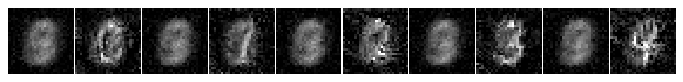

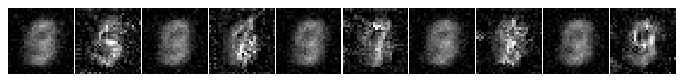

classifier 1:


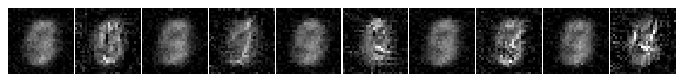

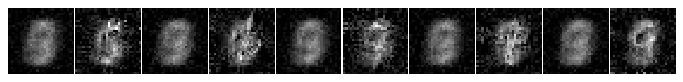

classifier 2:


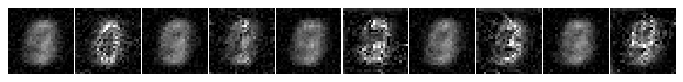

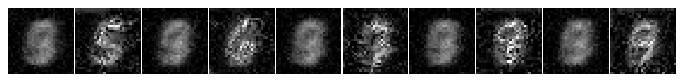

classifier 3:


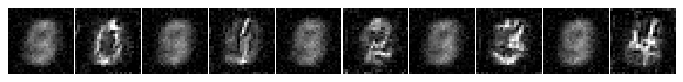

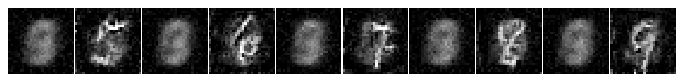

classifier 4:


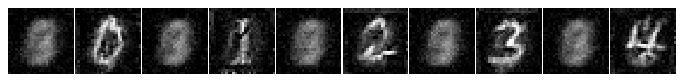

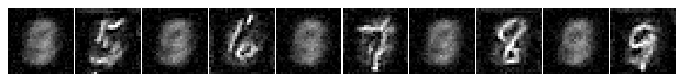

In [8]:
EvaluationUtil.generate_images_with_classifier(classifiers, ds, 10, 0.1, "scaled_l_2", 0.3, pairs_in_line=5, nrow=10)

### Train/Load GANs separately for each class

generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


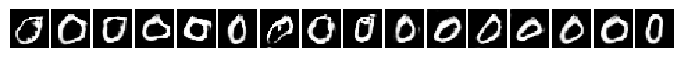

generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


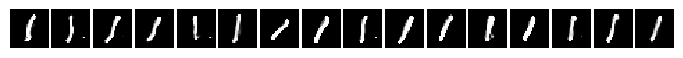

generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


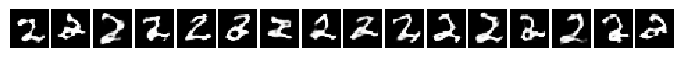

generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


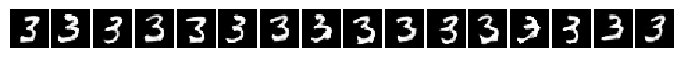

generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


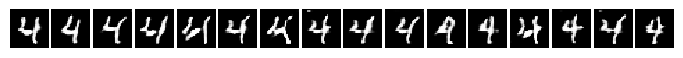

generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


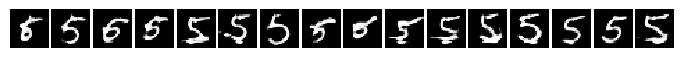

generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


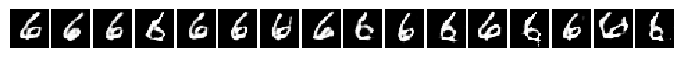

generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


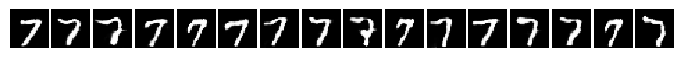

generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


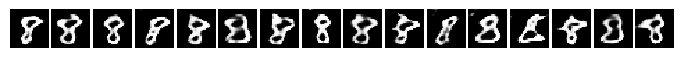

generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


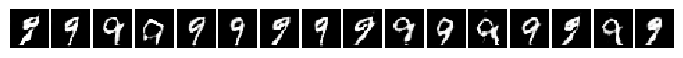

In [21]:
train = False

for class_id in range(10):
    filename = f"mnist-gan/dumped_weights_{class_id}.bin"
    loader = Util.class_specific_loader(class_id, ds.get_unaugmented_train_loader)
    g = GAN()
    if train:
        g.fit(loader, epochs=100, lr=1e-3, n_critic=5)
        g.save_params_to_disk(filename)
    else:
        g.restore_params_from_disk(filename)
        #g.legacy_restore_params_from_disk(filename)
        #g.save_params_to_disk(filename)
    images = g.generate(16)
    Util.imshow_tensors(images, nrow=len(images))

### See reconstructed and generated images using the interface of GenerativeModel

generator: 42051 trainable parameters
discriminator: 41221 trainable parameters
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


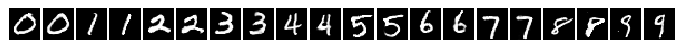

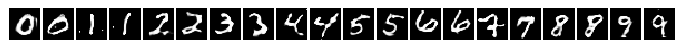

In [22]:
reconstructed_images, generated_images = [], []
for class_id in range(10):
    gm = WGAN(ds, class_id, ds)
    img, _ = next(gm.get_sampler())
    reconstructed_images += [img, gm.decode(gm.encode(img))]
    generated_images += [gm.generate(), gm.generate()]
Util.imshow_tensors(*reconstructed_images, nrow=20)
Util.imshow_tensors(*generated_images, nrow=20)